In [107]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Standard library
from pprint import pprint
import os
from typing import Dict, List, Tuple
from functools import reduce

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import balanced_accuracy_score, log_loss, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import NotFittedError
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.metrics import classification_report_imbalanced

# Hyperparameter tuning
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

# XGBoost
import xgboost as xgb

# Custom modules and other
import joblib

print('XGB Version',xgb.__version__)

XGB Version 1.7.2


## Global Settings

In [22]:
seed = 17
rs = np.random.RandomState(seed)

# Folds
folds = 5

# Paths
data_path = '../data/train_test/'
model_path = '../outputs/models/'
pipe_path = '../outputs/pipeline/'
plot_path = '../outputs/plots/'

top_num_features = 25

## Data

In [13]:
train_X, train_y = pd.read_parquet(data_path + 'train_X.parquet'), pd.read_parquet(data_path + 'train_y.parquet').to_numpy().reshape(-1,)

In [14]:
train_X.shape, train_y.shape

((81412, 49), (81412,))

## Hyperparameter Search Using Bayesian Optimization

The models with default parameters suffer from severe overfitting. We need to optimize the hyperparameter to reduce the variance. We will use Bayesian optimization to search through the hyperparameter search space. The `hyperopt` package's implementation of the Tree-structured Parzen Estimator algorithm is what we will use.

* First, define the search space:

In [10]:
# Search space
search_space = {
        # booster parameters
        'booster_params': {
                'booster': 'gbtree',
                'objective': 'multi:softprob',
                'num_class': 3,
                'learning_rate': hp.uniform('learning_rate', 0.001, 0.3), # Range: [0, 1], larger eta shrinks the feature weights more to make the boosting process more conservative, i.e., fewer trees (regularizer)
                'gamma': hp.randint('gamma', 0, 9), # Range: [0, inf], the larger the more conservative the algorithm (regularizer)
                'max_delta_step': hp.randint('max_delta_step', 1, 10), # Range: [0, inf], values from 1-10 might help control the update for imbalanced data (regularizer)
                'lambda': hp.choice('lambda', [1, 10, 100]), # Range: [0, inf], L2 regularization term on weights, the larger the more conservative the algorithm (regularizer)
                'alpha': hp.choice('alpha', [1, 10, 100]), # Range: [0, inf], L1 regularization term on weights, the larger the more conservative the algorithm (regularizer)
                'colsample_bylevel': hp.choice('colsample_bylevel', np.linspace(0.5, 1, 6).tolist()),
                'colsample_bynode': hp.choice('colsample_bynode', np.linspace(0.5, 1, 6).tolist()),
                'colsample_bytree': hp.choice('colsample_bytree', np.linspace(0.5, 1, 6).tolist()), # Range: (0, 1], subsample ratio of columns when constructing each tree, the smaller the more conservative the algorithm (regularizer)
                'subsample': hp.choice('subsample', np.linspace(0.5, 1, 6).tolist()), # Range: (0, 1], subsample ratio of the training instances every boosting iteration, the smaller the more conservative the algorithm (regularizer)
                'max_depth': hp.choice('max_depth', np.arange(3, 12, dtype=np.int16).tolist()), # Range: [0, inf], deep trees boost predictive power but are more likely to overfit (bias reducer)
                'tree_method': 'hist',
                'predictor': 'cpu_predictor',
                'eval_metric': 'mlogloss'
        },
        # Non-booster parameters
        'num_feat': hp.choice('num_feat', [50, 60, 70, 80]),
        'step': hp.choice('step', [0.1, 0.2, 0.3]),
        'k_neighbors': hp.choice('k_neighbors', [5, 10, 15, 20, 25, 30]),
        'num_boost_round': hp.randint('num_boost_round', 500, 2000), # Range: [0, inf], number of boosting iterations, the larger the more likely to overfit (bias reducer)
}

* Next, we define the objective function, which contains our cross-validation logic and returns the loss value we wish to minimize:

In [15]:
def objective(params: Dict):
    
    # Create copies since we passed mutable objects
    train_X, train_y = pd.read_parquet('../data/train_test/train_X.parquet'), pd.read_parquet('../data/train_test/train_y.parquet').to_numpy().reshape(-1,)
    folds = 2
    seed = 1227
    
    print(params)
    
    # Stratified K-fold cross-validation
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    losses = np.empty(folds)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
        
        # Train and validation sets
        fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
        fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]
        
        # Processing using fresh copies for every fold
        print(f'Start processing fold {fold + 1}...')
        preprocessor = joblib.load(pipe_path + 'preprocessor.joblib')
        label_encoder = joblib.load(pipe_path + 'label_encoder.joblib')
        # Fit and transform on training data
        fold_train_X = preprocessor.fit_transform(fold_train_X)
        fold_train_y = label_encoder.fit_transform(fold_train_y)
        # Transform validation data
        fold_val_X = preprocessor.transform(fold_val_X)
        fold_val_y = label_encoder.transform(fold_val_y)
        
        # Feature selection (tuning number of features and step size)
        selector = RFE(estimator=DecisionTreeClassifier(random_state=seed), n_features_to_select=int(params['num_feat']), step=float(params['step']))
        fold_train_X = selector.fit_transform(fold_train_X, fold_train_y)
        fold_val_X = selector.transform(fold_val_X)
        
        # Oversampling training data (tuning number of neighbors for SMOTE)
        print('Class distribution before oversampling:', np.unique(fold_train_y, return_counts=True)[1])
        smote = SMOTE(sampling_strategy='not majority', k_neighbors=int(params['k_neighbors']), random_state=seed)
        fold_train_X, fold_train_y = smote.fit_resample(fold_train_X, fold_train_y)
        print('Class distribution after oversampling:', np.unique(fold_train_y, return_counts=True)[1])
        
        # Model (tuning hyperparameters)
        print(f'Start training model for fold {fold + 1}...')
        feature_names = selector.get_feature_names_out().tolist()
        dtrain = xgb.DMatrix(data=fold_train_X, label=fold_train_y, feature_names=feature_names)
        dvalid = xgb.DMatrix(data=fold_val_X, label=fold_val_y, feature_names=feature_names)
        model = xgb.train(
            params=params['booster_params'],
            dtrain=dtrain,
            num_boost_round=int(params['num_boost_round']),
            early_stopping_rounds=400,
            evals=[(dtrain, 'train'), (dvalid, 'validate')], 
            verbose_eval=200
        )
        
        # Out-of-fold prediction for the current fold
        print(f'Predicting for fold {fold + 1}...')
        oof_pred = model.predict(data=dvalid)
        losses[fold] = log_loss(y_true=fold_val_y, y_pred=oof_pred)
        
    mean_log_loss = np.mean(losses)
        
    print(f'Average log loss: {mean_log_loss}')
    
    return {'loss': mean_log_loss, 'status': STATUS_OK}

* Minimize the objective function with the optimal value (multi-class log-loss) with respect to the hyperparameters:

In [16]:
trials = Trials()

best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

{'booster_params': {'alpha': 100, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7, 'colsample_bytree': 0.7, 'eval_metric': 'mlogloss', 'gamma': 8, 'lambda': 100, 'learning_rate': 0.006922847769586983, 'max_delta_step': 6, 'max_depth': 3, 'num_class': 3, 'objective': 'multi:softprob', 'predictor': 'cpu_predictor', 'subsample': 0.5, 'tree_method': 'hist'}, 'k_neighbors': 25, 'num_boost_round': 1002, 'num_feat': 60, 'step': 0.1}
Start processing fold 1...                             
Class distribution before oversampling:                
[ 4543 14218 21945]                                    
Class distribution after oversampling:                 
[21945 21945 21945]                                    
Start training model for fold 1...                     
[0]	train-mlogloss:1.09693	validate-mlogloss:1.09695   
[200]	train-mlogloss:0.93790	validate-mlogloss:0.94848 
[400]	train-mlogloss:0.88034	validate-mlogloss:0.90746 
[600]	train-mlogloss:0.84730	validate-mlogl

Based on the search, the best set of parameters are as follows:

In [20]:
best_params

{'alpha': 1,
 'colsample_bylevel': 3,
 'colsample_bynode': 5,
 'colsample_bytree': 3,
 'gamma': 1,
 'k_neighbors': 1,
 'lambda': 0,
 'learning_rate': 0.021239520998594802,
 'max_delta_step': 7,
 'max_depth': 4,
 'num_boost_round': 1014,
 'num_feat': 3,
 'step': 2,
 'subsample': 3}

Note that for `hp.choice`, the returned values is not the actual values of the hyperparamter but simply the indices to the choice lists. 

* The `colsample_bynode` returns $5$, which corresponds to the sixth element of the choice list--- `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`--- 1.0. 

* The `colsample_bytree` returns $3$, which correponds to  the fourth element of the choice list--- `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`--- 0.8.

We can simply use the dictionary from the standard output and modify as necessary.

In [17]:
optimal_params = {'booster_params': {
    'alpha': 10, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bynode': 1.0, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'gamma': 1, 
    'lambda': 1, 'learning_rate': 0.021239520998594802, 'max_delta_step': 7, 'max_depth': 7, 'num_class': 3, 'objective': 'multi:softprob', 'predictor': 'cpu_predictor', 
    'subsample': 0.8, 'tree_method': 'hist'
    }, 
 'k_neighbors': 10, 
 'num_boost_round': 10000, # Increase this to 2000 for better results
 'num_feat': 80, 
 'step': 0.3}
optimal_params

{'booster_params': {'alpha': 10,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bynode': 1.0,
  'colsample_bytree': 0.8,
  'eval_metric': 'mlogloss',
  'gamma': 1,
  'lambda': 1,
  'learning_rate': 0.021239520998594802,
  'max_delta_step': 7,
  'max_depth': 7,
  'num_class': 3,
  'objective': 'multi:softprob',
  'predictor': 'cpu_predictor',
  'subsample': 0.8,
  'tree_method': 'hist'},
 'k_neighbors': 10,
 'num_boost_round': 10000,
 'num_feat': 80,
 'step': 0.3}

We can now use this optimized set of parameters as a starting point for cross validation.

## Training with K-fold CV

In [20]:
# Out-of-fold prediction dictionary
oof = {}
# Feature importance container
feat_imp_list = []
# Classfication report container
clf_report_list = []
# CV splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
    
    # Print messages to console
    print('#'* 80)
    print('# Fold',fold + 1)
    print('# Training set size', len(train_idx), 'Validation set size', len(val_idx))
    print('#'* 80)
    
    # Check that the indices are indeed disjoint for training and validation set
    print('The training and validation sets are disjoint:', set(train_idx).isdisjoint(set(val_idx)))
    
    # Train and validation sets
    fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
    fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]
        
    # Preprocessing
    preprocessor = joblib.load('../outputs/pipeline/preprocessor.joblib')
    label_encoder = joblib.load('../outputs/pipeline/label_encoder.joblib')
    try:
        preprocessor.transform(train_X)
    except NotFittedError:
         print('The preprocessor is not fitted yet. Fitting now...')
    try:
        label_encoder.transform(train_y)
    except NotFittedError:
         print('The label encoder is not fitted yet. Fitting now...')
    # Fit and transform on training data
    fold_train_X = preprocessor.fit_transform(train_X)
    fold_train_y = label_encoder.fit_transform(train_y)
    # Transform validation data
    fold_val_X = preprocessor.transform(fold_val_X)
    fold_val_y = label_encoder.transform(fold_val_y)
    # Store fitted preprocessor and label encoder
    joblib.dump(preprocessor, f'../outputs/pipeline/preprocessor_fold_{fold + 1}.joblib')
    joblib.dump(label_encoder, f'../outputs/pipeline/label_encoder_fold_{fold + 1}.joblib')
    
    # Feature selection
    selector = RFE(estimator=DecisionTreeClassifier(random_state=rs), n_features_to_select=optimal_params['num_feat'], step=optimal_params['step'])
    try:
        selector.transform(fold_train_X)
    except NotFittedError:
         print('The feature selector is not fitted yet. Fitting now...')
    fold_train_X = selector.fit_transform(fold_train_X, fold_train_y)
    fold_val_X = selector.transform(fold_val_X)
    # Store fitted feature selector
    joblib.dump(selector, f'../outputs/pipeline/feature_selector_fold_{fold + 1}.joblib')
    
    # Oversampling training data
    print('Class distribution before oversampling:', np.unique(fold_train_y, return_counts=True)[1])
    smote = SMOTE(sampling_strategy='not majority', k_neighbors=optimal_params['k_neighbors'], random_state=rs)
    try:
        smote.get_feature_names_out()
    except ValueError:
        print('The resampler is not fitted yet. Fitting now...')
    fold_train_X, fold_train_y = smote.fit_resample(fold_train_X, fold_train_y)
    print('Class distribution after oversampling:', np.unique(fold_train_y, return_counts=True)[1])
    
    # Model 
    dtrain = xgb.DMatrix(data=fold_train_X, label=fold_train_y, feature_names=selector.get_feature_names_out().tolist())
    dvalid = xgb.DMatrix(data=fold_val_X, label=fold_val_y, feature_names=selector.get_feature_names_out().tolist())
    model = xgb.train(
        params=optimal_params['booster_params'],
        dtrain=dtrain,
        num_boost_round=optimal_params['num_boost_round'],
        early_stopping_rounds=400,
        evals=[(dtrain, 'train'), (dvalid, 'validate')], 
        verbose_eval=1000
    )
    model.save_model(model_path + f'model_fold_{fold + 1}.xgb')
    
    # Feature importance for the current fold
    # The booster object has a get_score method that returns a dictionary of feature names and their importance scores
    feat_imp = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature': feat_imp.keys(), f'importance_{fold + 1}': feat_imp.values()})
    # Add the current fold's feature importance to the container
    feat_imp_list.append(df)
    
    # Out-of-fold prediction, matrix of probabilities with shape (n_samples, n_classes)
    oof_pred = model.predict(dvalid)
    pred_classes = np.argmax(oof_pred, axis=1)
    # Add the current fold's out-of-fold prediction to the dictionary with target values
    oof[f'fold_{fold + 1}'] = {'target': fold_val_y, 'prediction': oof_pred}
    # Add report to container
    clf_report_list.append(classification_report_imbalanced(y_true=fold_val_y, y_pred=pred_classes, output_dict=True))
    # Print multi-class logloss and balanced accuracy (average recall (i.e., the ability of the classifier to find all the positive samples) for each class)
    print('Multi-class logloss:', log_loss(y_true=fold_val_y, y_pred=oof_pred, labels=[0, 1, 2]))
    print('Balanced accuracy (Average recall):', balanced_accuracy_score(y_true=fold_val_y, y_pred=pred_classes))
    print(classification_report_imbalanced(y_true=fold_val_y, y_pred=pred_classes))
    
    del fold_train_X, fold_train_y, fold_val_X, fold_val_y, dtrain, dvalid, model, feat_imp, oof_pred, pred_classes

################################################################################
# Fold 1
# Training set size 65129 Validation set size 16283
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/preprocessor_fold_1.joblib']

['../outputs/pipeline/label_encoder_fold_1.joblib']

/home/ubuntu/miniconda3/envs/my_compute/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_1.joblib']

Class distribution before oversampling: [ 9085 28436 43891]
The resampler is not fitted yet. Fitting now...
Class distribution after oversampling: [43891 43891 43891]
[0]	train-mlogloss:1.08845	validate-mlogloss:1.09113
[1000]	train-mlogloss:0.53024	validate-mlogloss:0.80940
[2000]	train-mlogloss:0.47064	validate-mlogloss:0.78136
[3000]	train-mlogloss:0.44456	validate-mlogloss:0.76979
[4000]	train-mlogloss:0.43114	validate-mlogloss:0.76326
[5000]	train-mlogloss:0.42237	validate-mlogloss:0.75910
[6000]	train-mlogloss:0.41539	validate-mlogloss:0.75606
[7000]	train-mlogloss:0.40996	validate-mlogloss:0.75337
[8000]	train-mlogloss:0.40587	validate-mlogloss:0.75141
[9000]	train-mlogloss:0.40194	validate-mlogloss:0.74948
[9999]	train-mlogloss:0.39873	validate-mlogloss:0.74785
Multi-class logloss: 0.7478507008823111
Balanced accuracy (Average recall): 0.5231483815217848
                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.25      0.9

['../outputs/pipeline/preprocessor_fold_2.joblib']

['../outputs/pipeline/label_encoder_fold_2.joblib']

/home/ubuntu/miniconda3/envs/my_compute/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_2.joblib']

Class distribution before oversampling: [ 9085 28436 43891]
The resampler is not fitted yet. Fitting now...
Class distribution after oversampling: [43891 43891 43891]
[0]	train-mlogloss:1.08844	validate-mlogloss:1.09078
[1000]	train-mlogloss:0.52905	validate-mlogloss:0.81205
[2000]	train-mlogloss:0.46965	validate-mlogloss:0.78548
[3000]	train-mlogloss:0.44314	validate-mlogloss:0.77362
[4000]	train-mlogloss:0.42977	validate-mlogloss:0.76731
[5000]	train-mlogloss:0.42130	validate-mlogloss:0.76335
[6000]	train-mlogloss:0.41425	validate-mlogloss:0.76015
[7000]	train-mlogloss:0.40870	validate-mlogloss:0.75754
[8000]	train-mlogloss:0.40453	validate-mlogloss:0.75559
[9000]	train-mlogloss:0.40107	validate-mlogloss:0.75400
[9999]	train-mlogloss:0.39801	validate-mlogloss:0.75246
Multi-class logloss: 0.7524566794666495
Balanced accuracy (Average recall): 0.5328806383228937
                   pre       rec       spe        f1       geo       iba       sup

          0       0.53      0.29      0.9

['../outputs/pipeline/preprocessor_fold_3.joblib']

['../outputs/pipeline/label_encoder_fold_3.joblib']

/home/ubuntu/miniconda3/envs/my_compute/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_3.joblib']

Class distribution before oversampling: [ 9085 28436 43891]
The resampler is not fitted yet. Fitting now...
Class distribution after oversampling: [43891 43891 43891]
[0]	train-mlogloss:1.08874	validate-mlogloss:1.09098
[1000]	train-mlogloss:0.53139	validate-mlogloss:0.83072
[2000]	train-mlogloss:0.47135	validate-mlogloss:0.80426
[3000]	train-mlogloss:0.44529	validate-mlogloss:0.79239
[4000]	train-mlogloss:0.43074	validate-mlogloss:0.78547
[5000]	train-mlogloss:0.42167	validate-mlogloss:0.78172
[6000]	train-mlogloss:0.41443	validate-mlogloss:0.77853
[7000]	train-mlogloss:0.40911	validate-mlogloss:0.77593
[8000]	train-mlogloss:0.40492	validate-mlogloss:0.77388
[9000]	train-mlogloss:0.40142	validate-mlogloss:0.77237
[9999]	train-mlogloss:0.39841	validate-mlogloss:0.77092
Multi-class logloss: 0.770919568089847
Balanced accuracy (Average recall): 0.4961868231467715
                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.23      0.98

['../outputs/pipeline/preprocessor_fold_4.joblib']

['../outputs/pipeline/label_encoder_fold_4.joblib']

/home/ubuntu/miniconda3/envs/my_compute/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_4.joblib']

Class distribution before oversampling: [ 9085 28436 43891]
The resampler is not fitted yet. Fitting now...
Class distribution after oversampling: [43891 43891 43891]
[0]	train-mlogloss:1.08889	validate-mlogloss:1.09128
[1000]	train-mlogloss:0.53356	validate-mlogloss:0.80626
[2000]	train-mlogloss:0.47320	validate-mlogloss:0.77772
[3000]	train-mlogloss:0.44720	validate-mlogloss:0.76519
[4000]	train-mlogloss:0.43358	validate-mlogloss:0.75876
[5000]	train-mlogloss:0.42403	validate-mlogloss:0.75426
[6000]	train-mlogloss:0.41704	validate-mlogloss:0.75095
[7000]	train-mlogloss:0.41220	validate-mlogloss:0.74846
[8000]	train-mlogloss:0.40783	validate-mlogloss:0.74620
[9000]	train-mlogloss:0.40401	validate-mlogloss:0.74432
[9999]	train-mlogloss:0.40082	validate-mlogloss:0.74268
Multi-class logloss: 0.7426773627769532
Balanced accuracy (Average recall): 0.5322348848702568
                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.26      0.9

['../outputs/pipeline/preprocessor_fold_5.joblib']

['../outputs/pipeline/label_encoder_fold_5.joblib']

/home/ubuntu/miniconda3/envs/my_compute/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_5.joblib']

Class distribution before oversampling: [ 9085 28436 43891]
The resampler is not fitted yet. Fitting now...
Class distribution after oversampling: [43891 43891 43891]
[0]	train-mlogloss:1.08903	validate-mlogloss:1.09133
[1000]	train-mlogloss:0.53021	validate-mlogloss:0.81383
[2000]	train-mlogloss:0.46897	validate-mlogloss:0.79257
[3000]	train-mlogloss:0.44152	validate-mlogloss:0.78082
[4000]	train-mlogloss:0.42662	validate-mlogloss:0.77500
[5000]	train-mlogloss:0.41738	validate-mlogloss:0.77083
[6000]	train-mlogloss:0.41053	validate-mlogloss:0.76801
[7000]	train-mlogloss:0.40501	validate-mlogloss:0.76551
[8000]	train-mlogloss:0.40045	validate-mlogloss:0.76339
[9000]	train-mlogloss:0.39680	validate-mlogloss:0.76182
[9999]	train-mlogloss:0.39374	validate-mlogloss:0.76048
Multi-class logloss: 0.7604833171024694
Balanced accuracy (Average recall): 0.570179560010352
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.40      0.95

## Performance on Validation Set

One quick way to benchmark our test prediction is using the multi-class log-loss:

In [76]:
for fold in range(4):
    print(log_loss(y_true=oof[f'fold_{fold + 1}']['target'], y_pred=oof[f'fold_{fold + 1}']['prediction'], labels=[0, 1, 2]))

0.7478507008823111
0.7524566794666495
0.770919568089847
0.7426773627769532


A random guess model, when the dataset is imbalanced, simply uses the overall proportions of the traning examples belonging to each class as the predicted probabilities of each class.

In [87]:
def rand_guess_log_loss(class_ratio, sample_size):
    
    if sum(class_ratio) != 1.0:
        class_ratio[-1] += 1 - sum(class_ratio) # Adjust last class ratio to make the sum equal to 1
    
    true_y = []
    for ith_class_label, ith_class_ratio in enumerate(class_ratio):
        true_y = true_y + [ith_class_label for val in range(int(ith_class_ratio * sample_size))]
        
    # The 'random guess' predictions simply predict the class ratios
    preds=[]
    for i in range(sample_size):
        preds += [class_ratio]

    return log_loss(true_y, preds)

In [102]:
class_ratios = np.unique(oof[f'fold_1']['target'], return_counts=True)[1] / len(oof[f'fold_1']['target'])
class_ratios

array([0.11158877, 0.34932138, 0.53908985])

In [103]:
rand_guess_log_loss(class_ratios, sample_size=len(oof[f'fold_1']['target']))

0.9451992596686541

As can be seen, our log loss values are all lower than this benchmark.

In [123]:
label_encoder.classes_

array(['<30', '>30', 'NO'], dtype=object)

### Confusion Matrix

In [125]:
labels

array(['<30', '>30', 'NO'], dtype=object)

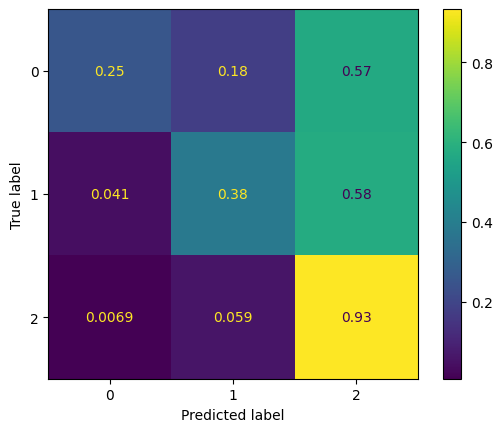

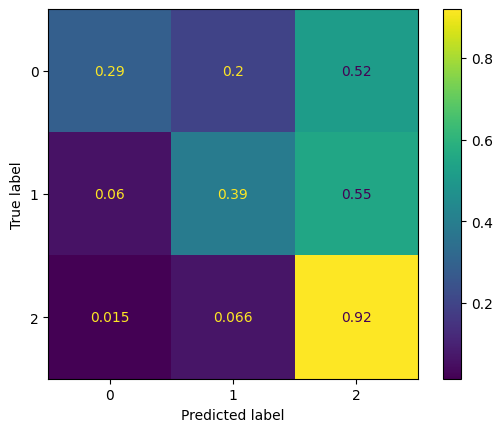

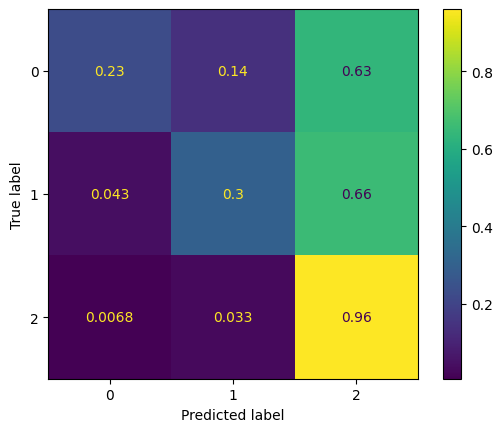

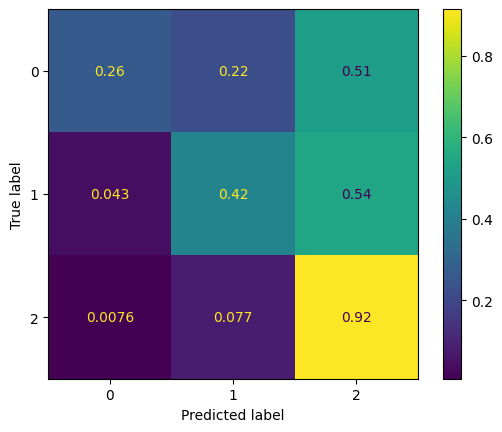

In [138]:
for fold in range(4):
    # Compute predictions for the current fold
    ConfusionMatrixDisplay(confusion_matrix(y_true=oof[f'fold_{fold + 1}']['target'], y_pred=np.argmax(oof[f'fold_{fold + 1}']['prediction'], axis=1), labels=[0, 1, 2], normalize='true')).plot();
    plt.show()

Due to the nature of the problem, we would likely wish to focus on the top row. Specifically, we would want to maximize the top left corner, which corresponds to cases where the model correctly classified patient as a member of the '<30' group, i.e., the patient was readmitted into the hospital within 30 days. This is because the cost of miss-classifying a patient who is a high-risk in terms of within 30-day readmission is very high. 

* Even though our model out performs the random guessing model. It still remains suboptimal in terms of our objective--- maximizing the classifier's ability to correctly identify patients who are high-risk of readmission. 

* For the first fold, the classifier correctly classified class 0 ('<30') patients $26\%$ of the time; however, its false negative rate is $73\%$, which is too high. This performance is consistent across all folds.

## Feature Importance

In [21]:
# Order the feature importance for each fold
for i in range(5):
    feat_imp_list[i].sort_values(by=f'importance_{i + 1}', ascending=True, inplace=True)

In [36]:
feat_imp = reduce(lambda x, y: pd.merge(x.iloc[-top_num_features:], y.iloc[-top_num_features:], on='feature', how='left'), feat_imp_list)
feat_imp

,feature,importance_1,importance_2,importance_3,importance_4,importance_5
0,number_inpatient_max_by_patient_nbr,10015.0,9602.0,9626.0,9908.0,9836.0
1,admission_source_id,10282.0,10191.0,10436.0,10657.0,10056.0
2,number_inpatient_mean_by_patient_nbr,10711.0,NaN,NaN,10625.0,10683.0
3,time_in_hospital_mean_by_patient_nbr,10764.0,10896.0,10737.0,10908.0,10554.0
4,time_in_hospital_sum_by_patient_nbr,10828.0,10234.0,10831.0,10597.0,10812.0
5,num_medications_median_by_patient_nbr,10859.0,10815.0,10832.0,10785.0,10984.0
6,insulin,11258.0,10972.0,11422.0,11505.0,11268.0
7,admission_type_id,11397.0,10999.0,11419.0,11315.0,11013.0
8,num_medications_mean_by_patient_nbr,12050.0,11707.0,11982.0,12315.0,11982.0
9,number_diagnoses_sum_by_patient_nbr,12113.0,12008.0,12356.0,12365.0,12327.0


As can be seen, all five folds agree on these feature importances except for `number_inpatient_mean_by_patient_nbr`, which are not in the top 25 for fold two and three. We can extract its importance weights from thoes folds and replace the nan's in the data frame above.

In [ ]:
feat_imp['importance_2'].fillna(feat_imp_list[1].loc[feat_imp_list[1]['feature'] == 'number_inpatient_mean_by_patient_nbr', 'importance_2'].values[0], inplace=True)
feat_imp['importance_3'].fillna(feat_imp_list[2].loc[feat_imp_list[2]['feature'] == 'number_inpatient_mean_by_patient_nbr', 'importance_3'].values[0], inplace=True)

Compute the average importance across all five folds:

In [55]:
feat_imp['avg_importance'] = feat_imp.iloc[:, 1:].apply(lambda x: x.mean(), axis=1)
feat_imp

,feature,importance_1,importance_2,importance_3,importance_4,importance_5,avg_importance
0,number_inpatient_max_by_patient_nbr,10015.0,9602.0,9626.0,9908.0,9836.0,9797.4
1,admission_source_id,10282.0,10191.0,10436.0,10657.0,10056.0,10324.4
2,number_inpatient_mean_by_patient_nbr,10711.0,8387.0,8156.0,10625.0,10683.0,9712.4
3,time_in_hospital_mean_by_patient_nbr,10764.0,10896.0,10737.0,10908.0,10554.0,10771.8
4,time_in_hospital_sum_by_patient_nbr,10828.0,10234.0,10831.0,10597.0,10812.0,10660.4
5,num_medications_median_by_patient_nbr,10859.0,10815.0,10832.0,10785.0,10984.0,10855.0
6,insulin,11258.0,10972.0,11422.0,11505.0,11268.0,11285.0
7,admission_type_id,11397.0,10999.0,11419.0,11315.0,11013.0,11228.6
8,num_medications_mean_by_patient_nbr,12050.0,11707.0,11982.0,12315.0,11982.0,12007.2
9,number_diagnoses_sum_by_patient_nbr,12113.0,12008.0,12356.0,12365.0,12327.0,12233.8


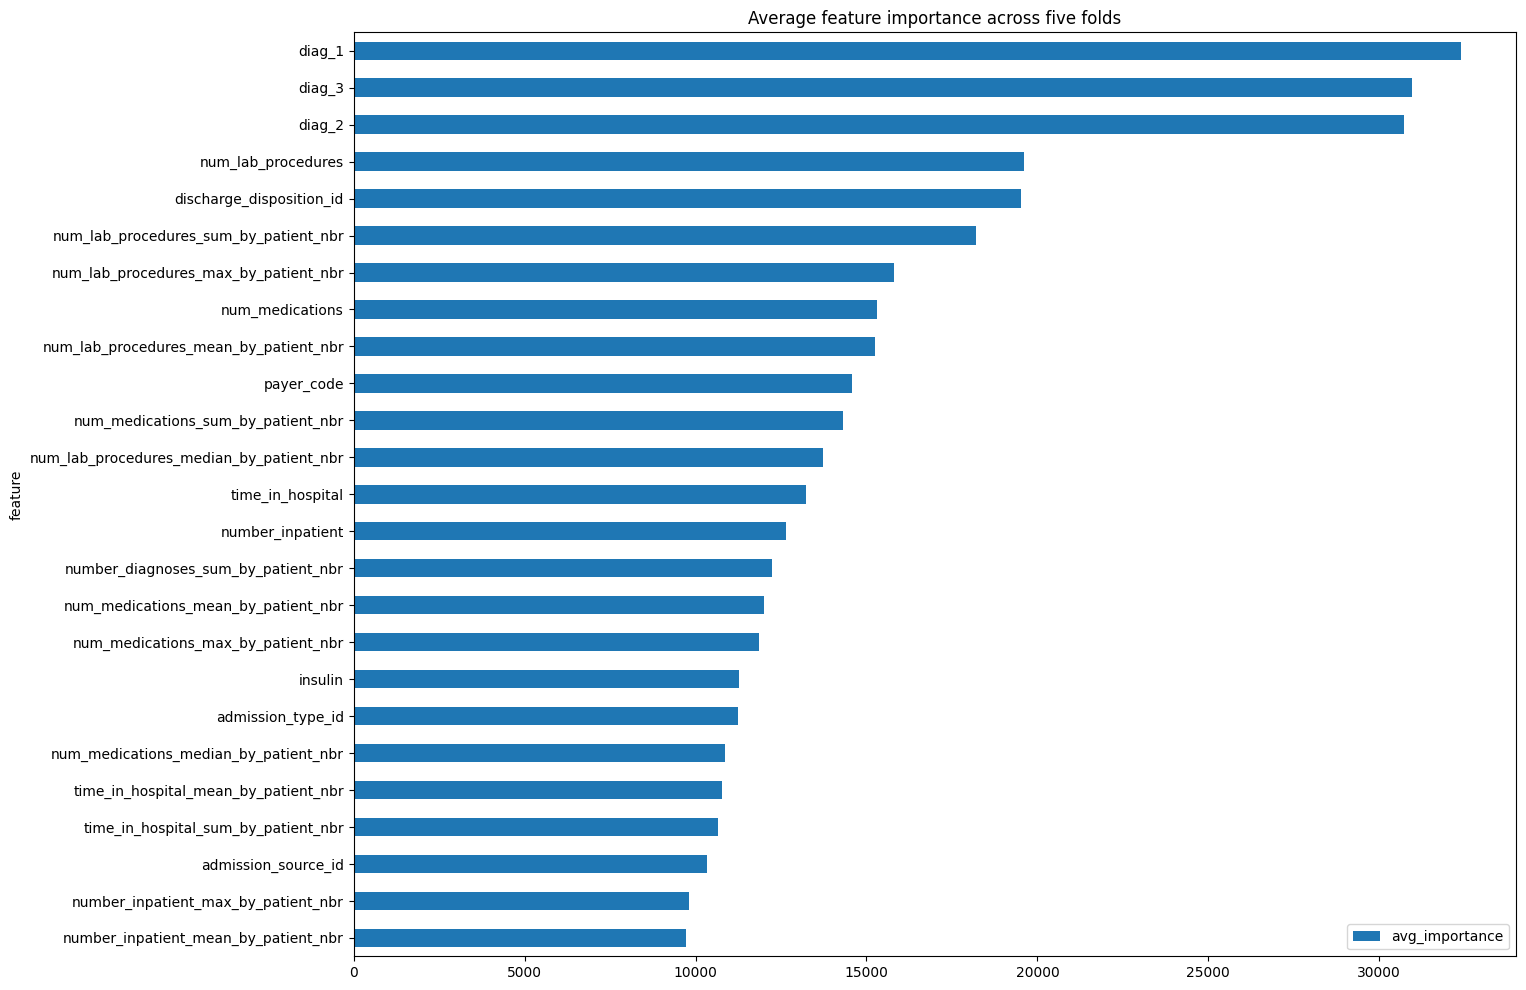

In [65]:
feat_imp_plot = feat_imp.sort_values(by='avg_importance').plot(kind='barh', x='feature', y='avg_importance', figsize=(15, 12), title='Average feature importance across five folds')
feat_imp_plot.figure.savefig('../outputs/plots/feature_importance.pdf', bbox_inches='tight')

## Predictions on Test Data

Take the average of each model's predictions:

In [74]:
test_X, test_y = pd.read_parquet(data_path + 'test_X.parquet'), pd.read_parquet(data_path + 'test_y.parquet').to_numpy().reshape(-1,)
test_X.shape, test_y.shape

((20354, 49), (20354,))

In [147]:
test_y = joblib.load('../outputs/pipeline/label_encoder.joblib').fit_transform(test_y)
test_y

array([2, 2, 2, ..., 1, 1, 1])

In [68]:
pred = np.zeros(shape=(test_X.shape[0], 3))
for i in range(5):
    # Initialize the model
    model = xgb.Booster()
    # Load the model
    model.load_model(model_path + f'model_fold_{i + 1}.xgb')
    # Process test set
    fold_test_X = joblib.load(f'../outputs/pipeline/preprocessor_fold_{i + 1}.joblib').transform(test_X)
    fold_test_X = joblib.load(f'../outputs/pipeline/feature_selector_fold_{i + 1}.joblib').transform(fold_test_X)
    # Make predictions on the test set and sum the matrices of probabilities with shape (n_samples, n_classes) element-wise
    pred += model.predict(xgb.DMatrix(data=fold_test_X))
# Average the predictions
pred /= 5
pred = pred.astype('float64')

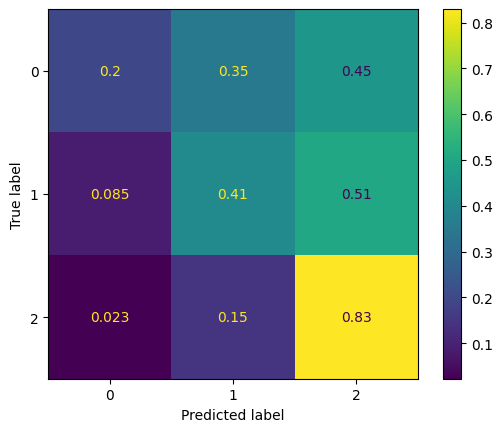

In [148]:
ConfusionMatrixDisplay(confusion_matrix(y_true=test_y, y_pred=np.argmax(pred, axis=1), labels=[0, 1, 2], normalize='true')).plot();
plt.show()

In [150]:
log_loss(y_true=test_y, y_pred=pred)

0.8513914379491603